In [1]:
import os 
import sys
import glob
import requests as req
import re
import pprint

In [2]:
import collections
import functools
import itertools
from itertools import product

In [3]:
import numpy as np
import pandas as pd
import numba as nb
import numexpr as ne
from scipy.special import gamma, binom

In [4]:
from IPython.display import display

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
def download_file(url, file, chunk_size=8192):
    """Download from 'url' save into 'file'."""
    with req.get(url, stream=True) as r:
        r.raise_for_status()
        with open(file, "wb") as f:
            for chunk in r.iter_content(chunk_size=chunk_size):
                if chunk:
                    f.write(chunk)
                    f.flush()
    return file

In [7]:
# download all daily observations

for x in ("confirmed", "deaths", "recovered"):
    url = f"https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_{x}_global.csv"
    file = f"time_series_covid19_{x}_global.csv"
    download_file(url, file)

In [8]:
! ls *.csv

time_series_covid19_confirmed_global.csv
time_series_covid19_deaths_global.csv
time_series_covid19_recovered_global.csv


In [9]:
# load all data as is

CSV = {
    c.split("/")[-1].split("_")[-2]: pd.read_csv(c) for c in glob.iglob(f"time_series_covid19*global.csv")
}

In [10]:
POPULATION = pd.read_excel(
    "population_per_country.xlsx", index_col="Name", usecols=["Name", "QTY"]
)
POPULATION.dropna(inplace=True)

In [11]:
# Clean up and pre-process

RENAME = {
    "Burma": "Myanmar",
    "Cabo Verde": "Cape Verde",
    "Congo (Brazzaville)": "Republic of the Congo",
    "Congo (Kinshasa)": "Democratic Republic of the Congo",
    "Cote d'Ivoire": "Ivory Coast",
    "Czechia": "Czech Republic",
    "Korea, South": "South Korea",
    "Sao Tome and Principe": "São Tomé and Príncipe",
    "Taiwan*": "Taiwan",
    "Timor-Leste": "East Timor",
    "US": "United States",
}

DATA = []

for stat, df in CSV.items():

    # remove useless rows if present
    if len({"Lat", "Long", "Province/State"} - set(df.columns)) == 0:
        del (
            df["Lat"],
            df["Long"],
            df["Province/State"],
        )

    # rename some countries
    for orig, new in RENAME.items():
        df.loc[df["Country/Region"] == orig, "Country/Region"] = new

    # sum up all provinces and transpose
    df = df.groupby("Country/Region").sum().T

    # remove non countires
    if len({"Diamond Princess", "Holy See", "MS Zaandam"} - set(df.columns)) == 0:
        del (
            df["Diamond Princess"],
            df["Holy See"],
            df["MS Zaandam"],
        )

    # set index to cumulative days
    df = df.set_index(np.arange(1, len(df) + 1))
    df.index.names = ["days"]

    # set columns to multiindex
    df.columns = pd.MultiIndex.from_arrays([list(df.columns), [stat] * len(df.columns)])

    # merge all into one df
    DATA.append(df)

DATA = pd.concat(DATA, axis=1)

In [12]:
{x[0] for x in DATA.columns} - set(POPULATION.index)

{'West Bank and Gaza'}

# Select Countries and Stats of Interest

In [13]:
Countries = [
    "Spain",
    "Netherlands",
#     "Italy",
#     "South Korea",
    "Germany",
    "Uzbekistan",
    "United States",
#     "Malaysia",
    "Russia",
    "Kazakhstan",
    "South Korea",
]
StatType = ["confirmed", "deaths", "recovered"]

In [14]:
# Sort acording to # cases

Countries = [x[1] for x in sorted(zip(DATA[product(Countries, ["confirmed"])].iloc[-1,:], Countries))[::-1]]

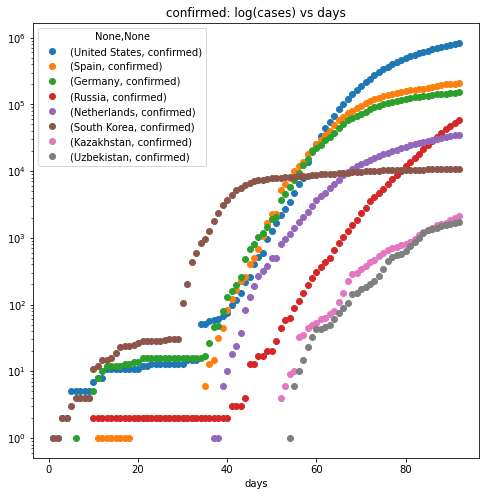

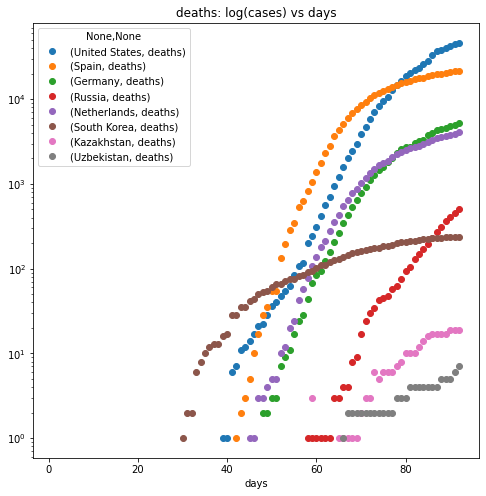

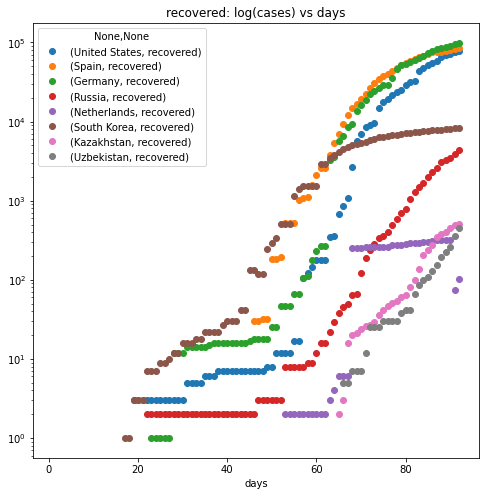

In [15]:
# log(cases) vs days
prodix = pd.MultiIndex.from_product

for stat in StatType:
    idx = prodix([Countries, [stat]])
    DATA[idx].plot(
        logy=True,
        legend=True,
        title=f"{stat}: log(cases) vs days",
        figsize=(8, 8),
        style="o",
    )

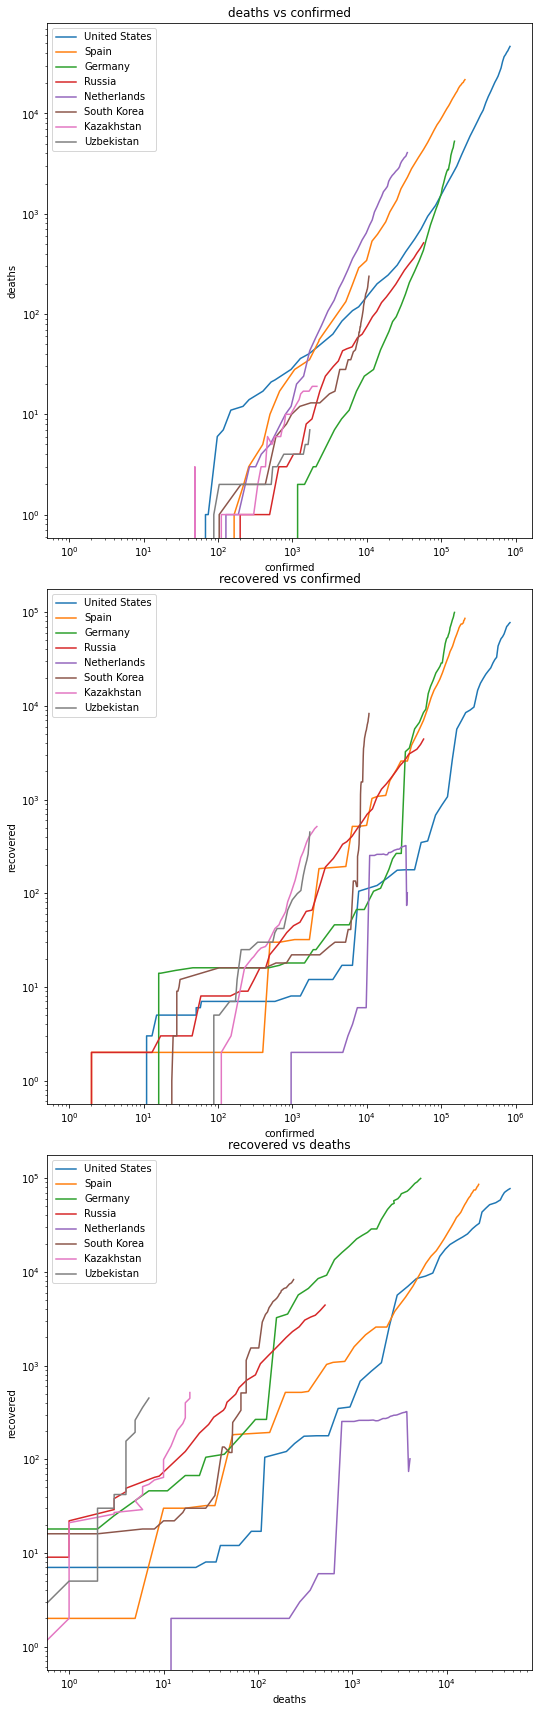

In [16]:
# loglog per country pairs of combinations of [confirmed, deaths, recovered]

combi = list(itertools.combinations(StatType, 2))
fig, axes = plt.subplots(len(combi), figsize=(8, 8*len(combi)))
plt.tight_layout(3)

for i, (xn, yn) in enumerate(combi):
    ax = axes[i]
    
    for ic, cnt in enumerate(Countries):
        x = DATA[cnt, xn]
        y = DATA[cnt, yn]
        ax.plot(x, y)


    ax.set_xlabel(xn)
    ax.set_xscale("log")

    ax.set_ylabel(yn)
    ax.set_yscale("log")

    ax.set_title(f"{yn} vs {xn}")
    ax.legend(Countries)

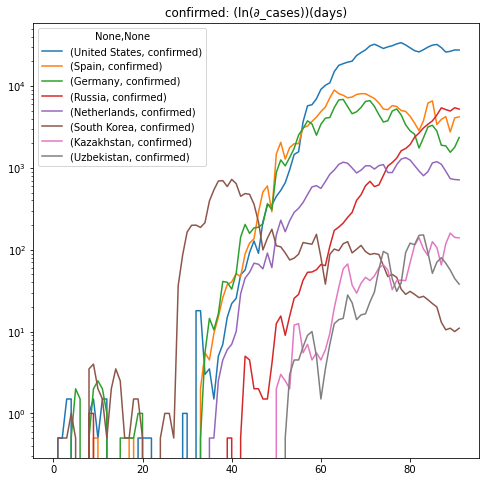

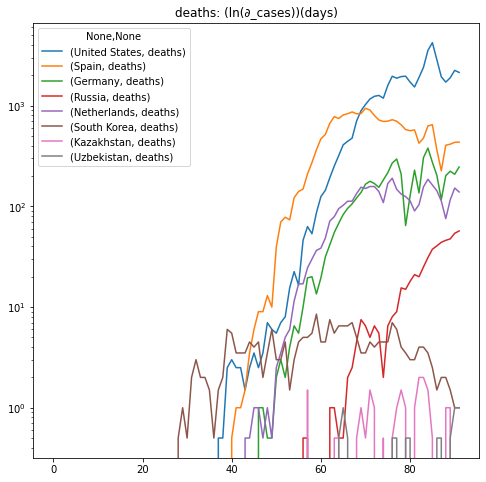

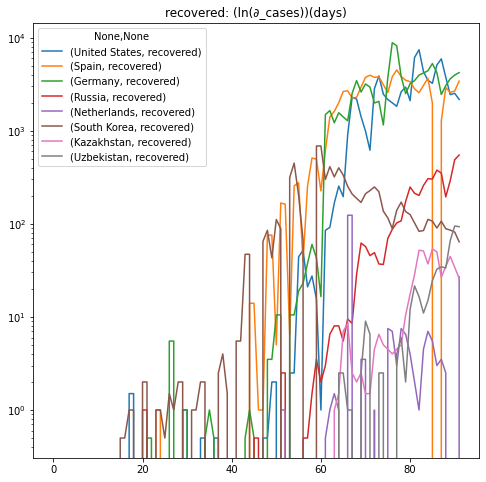

In [18]:
# derivative of cases(days)

DERIV = pd.DataFrame(np.gradient(DATA, axis=0), columns=DATA.columns,)

for stat in StatType:
    DERIV[product(Countries, [stat])].plot(
        logy=True,
        legend=True,
        title=f"{stat}: (ln(∂_cases))(days)",
        style="-",
        figsize=(8, 8),
    )

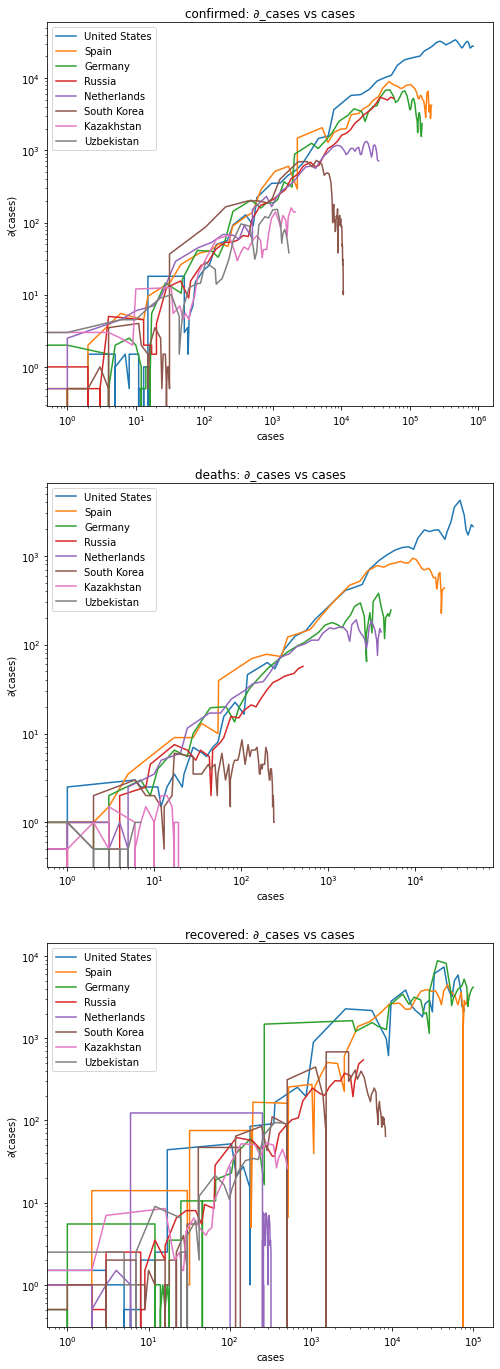

In [38]:
# ln(∂_cases) vs ln_cases

fig, axes = plt.subplots(len(StatType), figsize=(8, 8 * len(StatType)))

# Countries = ["United States", "Netherlands", "Italy", "Spain", "Malaysia"]
#Countries = ["Netherlands", "Spain", "United States", "Russia", ]


for i, stat in enumerate(StatType):
    ax = axes[i]
    ax.set_title(f"{stat}: ∂_cases vs cases")

    x = DATA[product(Countries, [stat])]
    y = DERIV[product(Countries, [stat])]

    ax.plot(x, y, "-")
    ax.set_xscale("log")
    ax.set_xlabel("cases")
    ax.set_yscale("log")
    ax.set_ylabel("∂(cases)")
    ax.legend(Countries)

# Normalize to the total country population 

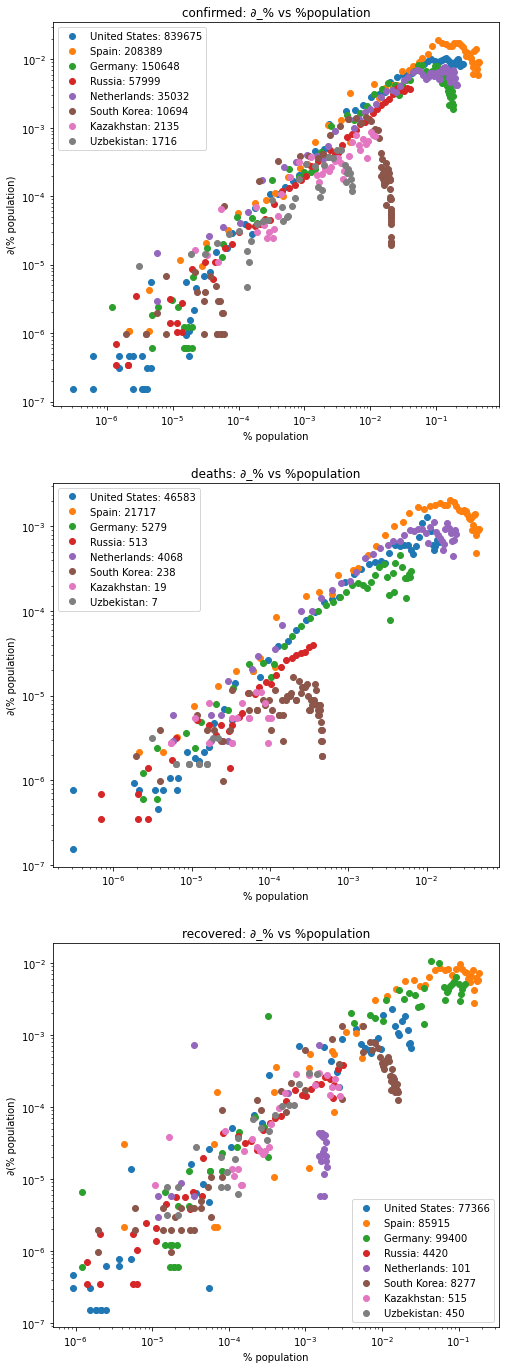

In [56]:
fig, axes = plt.subplots(len(StatType), figsize=(8, 8 * len(StatType)))

NORM = pd.DataFrame(DATA[Countries])

for i, case in enumerate(StatType):

    for c in Countries:
        xc = ((DATA[c, case] / POPULATION.loc[c, "QTY"]) * 100).values
        yc = np.gradient(xc, axis=0)
        NORM[c, case] = xc
        NORM[c, f"D({case})"] = yc

    X = NORM[product(Countries, [case])]
    Y = NORM[product(Countries, [f"D({case})"])]

    # plot
    ax = axes[i]
    ax.set_title(f"{case}: ∂_% vs %population")

    ax.plot(X, Y, "o")

    ax.set_xscale("log")
    ax.set_xlabel("% population")

    ax.set_yscale("log")
    ax.set_ylabel("∂(% population)")

#     ax.legend(Countries)
    ax.legend([f"{t}: {DATA[t, case].values[-1]}" for t in Countries])

# WORLD

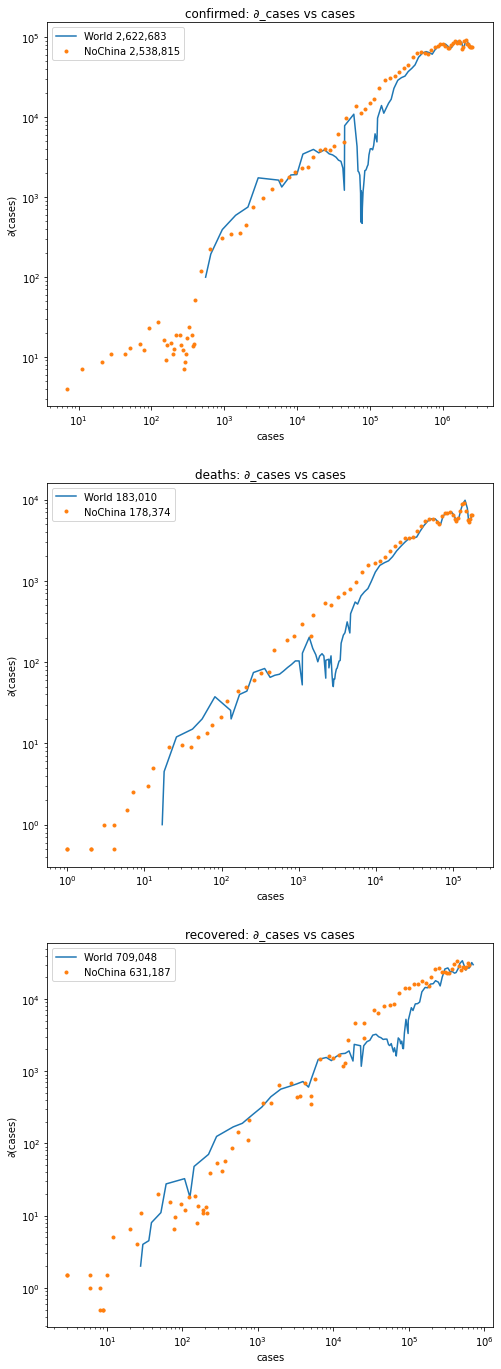

In [21]:
# ln(∂_cases) vs ln_cases

fig, axes = plt.subplots(len(StatType), figsize=(8, 8 * len(StatType)))

for i, stat in enumerate(StatType):
    # WORLD
    sel = product({x[0] for x in DATA.columns}, [stat])
    xw = DATA[sel].sum(axis=1).values
    yw = np.gradient(xw)

    # Except China
    no_china = product({x[0] for x in DATA.columns} - {"China"}, [stat])
    xnc = DATA[no_china].sum(axis=1).values
    ync = np.gradient(xnc)

    # plot
    ax = axes[i]
    ax.set_title(f"{stat}: ∂_cases vs cases")

    ax.plot(xw, yw, "-")
    ax.plot(xnc, ync, ".")

    ax.set_xscale("log")
    ax.set_xlabel("cases")

    ax.set_yscale("log")
    ax.set_ylabel("∂(cases)")

    ax.legend([f"World {xw[-1]:,}", f"NoChina {xnc[-1]:,}"])

# Merge Territories

In [22]:
Europe = {
    "Austria",
    "Belgium",
    "Bulgaria",
    "Croatia",
    "Cyprus",
    "Czech Republic",
    "Denmark",
    "Estonia",
    "Finland",
    "France",
    "Germany",
    "Greece",
    "Hungary",
    "Ireland",
    "Italy",
    "Latvia",
    "Lithuania",
    "Luxembourg",
    "Malta",
    "Netherlands",
    "Poland",
    "Portugal",
    "Romania",
    "Slovakia",
    "Slovenia",
    "Spain",
    "Sweden",
    "Switzerland",
    'United Kingdom',
}

In [23]:
Europe - {x[0] for x in DATA.columns}

set()

In [24]:
Africa = set(
    "Algeria | Angola | Benin | Botswana | Burkina Faso | Burundi | Cameroon | Cape Verde | Central African Republic | Chad | Comoros | Democratic Republic of the Congo | Djibouti | Egypt | Equatorial Guinea | Eritrea | Ethiopia | Gabon | Gambia | Ghana | Guinea | Guinea-Bissau | Ivory Coast | Kenya | Lesotho | Liberia | Libya | Madagascar | Malawi | Mali | Mauritania | Mauritius | Mayotte (overseas collectivity of France) | Morocco | Mozambique | Namibia | Niger | Nigeria | Republic of the Congo | Réunion (overseas region of France) | Rwanda | Saint Helena, Ascension and Tristan da Cunha (British overseas territory) | São Tomé and Príncipe | Senegal | Seychelles | Sierra Leone | Somalia | South Africa | South Sudan | Sudan | Eswatini | Tanzania | Togo | Tunisia | Uganda | Western Sahara | Zambia | Zimbabwe".split(
        " | "
    )
)

Africa - {x[0] for x in DATA.columns}

{'Comoros',
 'Lesotho',
 'Mayotte (overseas collectivity of France)',
 'Réunion (overseas region of France)',
 'Saint Helena, Ascension and Tristan da Cunha (British overseas territory)'}

In [25]:
MiddleEast = {
    "Bahrain",
    "Cyprus",
    "Egypt",
    "Gaza Strip",
    "Iran",
    "Iraq",
    "Israel",
    "Jordan",
    "Kuwait",
    "Lebanon",
    "Oman",
    "Qatar",
    "Saudi Arabia",
    "Syria",
    "Turkey",
    "United Arab Emirates",
    "West Bank",
    "Yemen",
}

MiddleEast - {x[0] for x in DATA.columns}

{'Gaza Strip', 'West Bank'}

In [26]:
SouthAmerica = set(
    "Argentina | Bolivia | Brazil | Chile | Colombia | Ecuador | Falkland Islands (British overseas territory) | French Guiana (French overseas region) | Guyana | Paraguay | Peru | Suriname | Uruguay | Venezuela".split(
        " | "
    )
)

SouthAmerica - {x[0] for x in DATA.columns}

{'Falkland Islands (British overseas territory)',
 'French Guiana (French overseas region)'}

In [27]:
SouthEastAsia = {
    "Brunei",
    "Cambodia",
    "East Timor",
    "Indonesia",
    "Laos",
    "Malaysia",
    "Myanmar",
    "Philippines",
    "Singapore",
    "Thailand",
    "Vietnam",
}

SouthEastAsia - {x[0] for x in DATA.columns}

set()

In [28]:
CentralAsia = {"Kazakhstan", "Kyrgyzstan", "Tajikistan", "Turkmenistan", "Uzbekistan"}

CentralAsia - {x[0] for x in DATA.columns}

{'Tajikistan', 'Turkmenistan'}

In [29]:
EasternEurope = {
    "Belarus",
    "Bulgaria",
    "Czech Republic",
    "Hungary",
    "Moldova",
    "Poland",
    "Romania",
    "Slovakia",
    "Ukraine",
}

EasternEurope - {x[0] for x in DATA.columns}

set()

In [30]:
NorthAmerica = set(
    "Antigua and Barbuda | Bahamas | Barbados | Belize | Bermuda | British Virgin Islands | Canada | Cayman Islands | Costa Rica | Cuba | Curacao | Dominica | Dominican Republic | El Salvador | Greenland | Grenada | Guadeloupe | Guatemala | Haiti | Honduras | Jamaica | Martinique | Mexico | Montserrat | Nicaragua | Panama | Puerto Rico | Saint Kitts and Nevis | Saint Lucia | Saint Pierre and Miquelon | Saint Vincent and the Grenadines | Sint Maarten | Trinidad and Tobago | Turks and Caicos Islands | United States | United States Virgin Islands".split(
        " | "
    )
)

NorthAmerica - {x[0] for x in DATA.columns}

{'Bermuda',
 'British Virgin Islands',
 'Cayman Islands',
 'Curacao',
 'Greenland',
 'Guadeloupe',
 'Martinique',
 'Montserrat',
 'Puerto Rico',
 'Saint Pierre and Miquelon',
 'Sint Maarten',
 'Turks and Caicos Islands',
 'United States Virgin Islands'}

In [31]:
Other = {x[0] for x in DATA.columns} - Europe - Africa - MiddleEast - SouthAmerica - SouthEastAsia - CentralAsia - EasternEurope - NorthAmerica

Other

{'Afghanistan',
 'Albania',
 'Andorra',
 'Armenia',
 'Australia',
 'Azerbaijan',
 'Bangladesh',
 'Bhutan',
 'Bosnia and Herzegovina',
 'China',
 'Fiji',
 'Georgia',
 'Iceland',
 'India',
 'Japan',
 'Kosovo',
 'Liechtenstein',
 'Maldives',
 'Monaco',
 'Mongolia',
 'Montenegro',
 'Nepal',
 'New Zealand',
 'North Macedonia',
 'Norway',
 'Pakistan',
 'Papua New Guinea',
 'Russia',
 'San Marino',
 'Serbia',
 'South Korea',
 'Sri Lanka',
 'Taiwan',
 'West Bank and Gaza'}

In [32]:
# merge larger territories
# "EU,Africa,MiddleEast,SouthAmerica,SouthEastAsia,CentralAsia,EasternEurope".split(",")

Countries_All = {x[0] for x in DATA.columns}

TERR = pd.DataFrame(index=DATA.index, columns=DATA.columns[:1])
TERR_PCT = pd.DataFrame(index=DATA.index, columns=DATA.columns[:1])

for stat in StatType:
    for terr, terr_set in zip(
        "Europe,Africa,MiddleEast,SouthAmerica,SouthEastAsia,CentralAsia,EasternEurope,NorthAmerica".split(
            ","
        ),
        (
            Europe,
            Africa,
            MiddleEast,
            SouthAmerica,
            SouthEastAsia,
            CentralAsia,
            EasternEurope,
            NorthAmerica,
        ),
    ):
        use_terr_set = Countries_All & terr_set
        TERR[terr, stat] = DATA[product(use_terr_set, [stat])].sum(axis=1)

        terr_popul = POPULATION.loc[use_terr_set, "QTY"].sum()
        TERR_PCT[terr, stat] = TERR[terr, stat] / terr_popul * 100

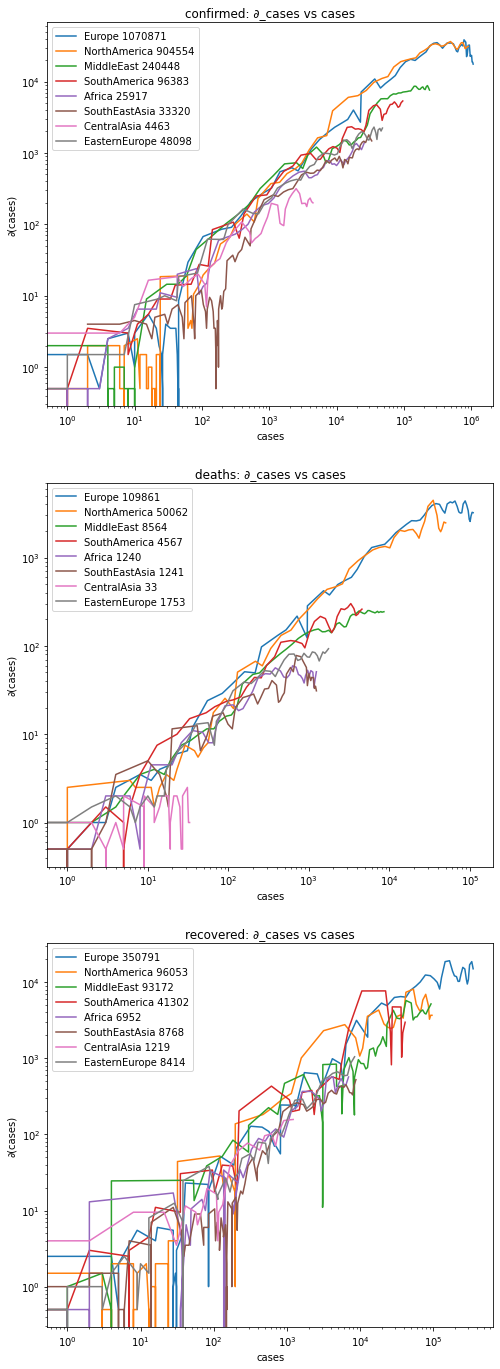

In [52]:
# ln(∂_cases) vs ln_cases

Territories = [
    "Europe",
    "NorthAmerica",
    "MiddleEast",
    "SouthAmerica",
    "Africa",
    "SouthEastAsia",
    "CentralAsia",
    "EasternEurope",
]

fig, axes = plt.subplots(len(StatType), figsize=(8, 8 * len(StatType)))

DTERR = pd.DataFrame(
    np.gradient(TERR[Territories], axis=0), columns=TERR[Territories].columns
)

for i, stat in enumerate(StatType):
    X = TERR[product(Territories, [stat])]
    Y = DTERR[product(Territories, [stat])]
    ax = axes[i]
    ax.set_title(f"{stat}: ∂_cases vs cases")
    ax.plot(X, Y, "-")
    ax.set_xscale("log")
    ax.set_xlabel("cases")

    ax.set_yscale("log")
    ax.set_ylabel("∂(cases)")
    ax.legend([f"{t} {TERR[t, stat].values[-1]}" for t in Territories])

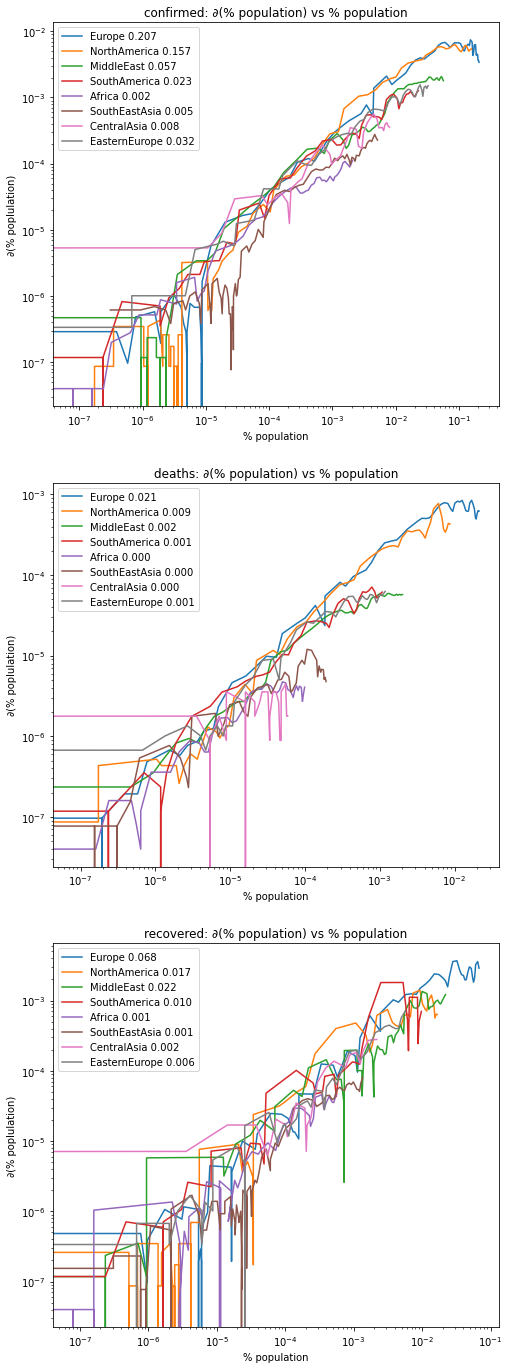

In [48]:
# % ln(∂_cases) vs ln_cases


fig, axes = plt.subplots(len(StatType), figsize=(8, 8 * len(StatType)))

DTERR_PCT = pd.DataFrame(
    np.gradient(TERR_PCT[Territories], axis=0), columns=TERR_PCT[Territories].columns
)

for i, stat in enumerate(StatType):
    X = TERR_PCT[product(Territories, [stat])]
    Y = DTERR_PCT[product(Territories, [stat])]
    ax = axes[i]
    ax.set_title(f"{stat}: ∂(% population) vs % population")
    ax.plot(X, Y, "-")
    ax.set_xscale("log")
    ax.set_xlabel("% population")

    ax.set_yscale("log")
    ax.set_ylabel("∂(% poplulation)")
    ax.legend([f"{t} {TERR_PCT[t, stat].values[-1]:.3f}" for t in Territories])

In [42]:
%debug

> /mnt/c/Apps/0/COVID-19/pandas/_libs/hashtable_class_helper.pxi(1627)pandas._libs.hashtable.PyObjectHashTable.get_item()

ipdb> u
> /mnt/c/Apps/0/COVID-19/pandas/_libs/hashtable_class_helper.pxi(1619)pandas._libs.hashtable.PyObjectHashTable.get_item()

ipdb> 
> /mnt/c/Apps/0/COVID-19/pandas/_libs/index.pyx(138)pandas._libs.index.IndexEngine.get_loc()

ipdb> 
> /mnt/c/Apps/0/COVID-19/pandas/_libs/index.pyx(111)pandas._libs.index.IndexEngine.get_loc()

ipdb> 
> /home/biosckon/anaconda3/envs/w4/lib/python3.8/site-packages/pandas/core/indexes/base.py(2648)get_loc()
   2646                 return self._engine.get_loc(key)
   2647             except KeyError:
-> 2648                 return self._engine.get_loc(self._maybe_cast_indexer(key))
   2649         indexer = self.get_indexer([key], method=method, tolerance=tolerance)
   2650         if indexer.ndim > 1 or indexer.size > 1:

ipdb> 
> /home/biosckon/anaconda3/envs/w4/lib/python3.8/site-packages/pandas/core/frame.py(2800)__getitem__()


In [35]:
nodata = set(POPULATION.index) - {x[0] for x in DATA.columns}

In [36]:
POPULATION.loc[nodata,:].sort_values(by="QTY")

,QTY
Name,
South Georgia and the South Sandwich Islands,30.0
Pitcairn Islands,56.0
French Southern And Antarctic lands,196.0
United States Minor Outlying Islands,300.0
Cocos Keeling Islands,550.0
...,...
Puerto Rico,3660000.0
Turkmenistan,5760000.0
Hong Kong,7360000.0


In [37]:
for c  in {x[0] for x in DATA.columns}:
    if "Kong" in c:print(c)

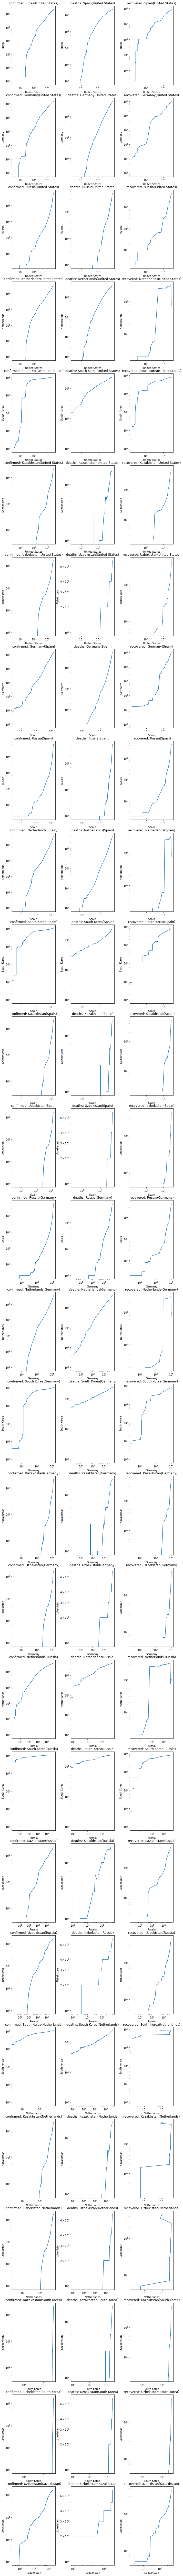

In [17]:
# loglog country1 vs country2

ncomb = int(binom(len(Countries), 2))
fig, axes = plt.subplots(ncomb, len(StatType), figsize=(10, ncomb * 5))
plt.tight_layout(3)

for i, stat in enumerate(StatType):
    for ic, (xn, yn) in enumerate(itertools.combinations(Countries, 2)):
        x = DATA[xn, stat]
        y = DATA[yn, stat]
        ax = axes[ic, i]
        ax.plot(x, y)

        ax.set_xscale("log")
        ax.set_xlabel(xn)

        ax.set_yscale("log")
        ax.set_ylabel(yn)

        ax.set_title(f"{stat}: {yn}({xn})")